[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Roboflow Video Inference with Custom Annotators
---

This tutorial shows how to use Roboflow's video inference API for quick predictions on local video files. We can use any model from Roboflow Universe and bypass the complexities of model training and focus on implementing a practical solution for video inference.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Installation
- Model Configuration
- Get predictions
- Data Preprocessing
- Video Annotation

## </> Let's begin!

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("I am here!", HOME)

I am here! /content


## Install Roboflow and other dependencies

In [3]:
%cd {HOME}

# install Roboflow
!pip -q install roboflow
# install Supervision
!pip -q install supervision

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
import numpy as np
import supervision as sv
import cv2

## Set Custom Model from Universe



We specify the Roboflow project and model version we want to use for our video inference. You can get the project name from the Roboflow Universe code snippet.

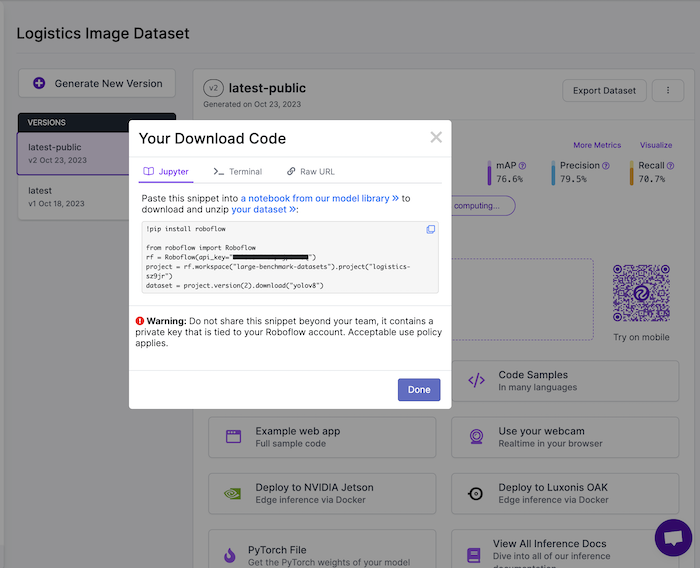

We submit our video file to the model for inference. This will return a job ID that we can use to poll for the results.

In [6]:
PROJECT_NAME = "logistics-sz9jr"
VIDEO_FILE = "example.mp4"
ANNOTATED_VIDEO = "annotated.mp4"

rf = Roboflow(api_key="UhiOc8NF1s2pYjp0zN3Q")
project = rf.workspace().project(PROJECT_NAME)
model = project.version(2).model

job_id, signed_url, expire_time = model.predict_video(
    VIDEO_FILE,
    fps=5,
    prediction_type="batch-video",
)

loading Roboflow workspace...
loading Roboflow project...


## Get Predictions

Once the video is processed, we retrieve the results using the job ID. This step is asynchronous and may take some time depending on the video length and complexity.

In [7]:
results = model.poll_until_video_results(job_id)
print(results)

Checking for video inference results for job 72ff8a22-77f8-4cbc-8665-7217ea56be9d every 60s
(0s): Checking for inference results
{'frame_offset': [0, 5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101, 107, 113, 119, 125, 131, 137, 143, 149, 155, 161, 167, 173, 179, 185, 191, 197, 203, 209, 215, 221, 227, 233, 239, 245, 251, 257, 263, 269, 275, 281, 287, 293, 299, 305, 311, 317, 323, 329, 335, 341, 347, 353, 359, 365, 371, 377, 383, 389, 395, 401, 407, 413, 419, 425, 431, 437, 443, 449, 455, 461, 467, 473, 479, 485, 491, 497, 503, 509, 515, 521, 527, 533, 539, 545, 551, 557, 563, 569, 575, 581, 587, 593, 599, 605, 611, 617, 623, 629, 635, 641, 647, 653, 659, 665, 671, 677, 683, 689, 695, 701, 707, 713, 719, 725, 731], 'time_offset': [0.0, 0.1668, 0.367, 0.5672, 0.7674, 0.9676, 1.1678, 1.368, 1.5682, 1.7684, 1.9686, 2.1688, 2.369, 2.5692, 2.7694, 2.9696, 3.1698, 3.37, 3.5702, 3.7704, 3.9706, 4.1708, 4.371, 4.5712, 4.7714, 4.9716, 5.1718, 5.372, 5.5722, 5.7724, 5.9726, 6.

## Data Preprocessing for Supervision

#### [Supervision Custom Annotations](https://supervision.roboflow.com/annotators/): You can choose any type of annotator. Formats are defined below for easy reference.

Before annotating our video, we must capture frame rate information and set up our annotators and tracker. This prepares us to process each frame with the predicted data.

In [8]:
box_mask_annotator = sv.BoxMaskAnnotator()
label_annotator = sv.LabelAnnotator()
tracker = sv.ByteTrack()
# box_annotator = sv.BoundingBoxAnnotator()
# halo_annotator = sv.HaloAnnotator()
# corner_annotator = sv.BoxCornerAnnotator()
# circle_annotator = sv.CircleAnnotator()
# blur_annotator = sv.BlurAnnotator()
# heat_map_annotator = sv.HeatMapAnnotator()

Here, we define `annotate_frame` function that processes each frame of the video. It uses the predictions to annotate the video frames with bounding boxes, labels, and other custom annotations.

In [9]:
cap = cv2.VideoCapture(VIDEO_FILE)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
cap.release()

def annotate_frame(frame: np.ndarray, frame_number: int) -> np.ndarray:
    try:
        time_offset = frame_number / frame_rate
        closest_time_offset = min(results['time_offset'], key=lambda t: abs(t - time_offset))
        index = results['time_offset'].index(closest_time_offset)
        detection_data = results[PROJECT_NAME][index]

        roboflow_format = {
            "predictions": detection_data['predictions'],
            "image": {"width": frame.shape[1], "height": frame.shape[0]}
        }
        detections = sv.Detections.from_roboflow(roboflow_format)
        detections = tracker.update_with_detections(detections)
        labels = [pred['class'] for pred in detection_data['predictions']]

    except (IndexError, KeyError, ValueError) as e:
        print(f"Exception in processing frame {frame_number}: {e}")
        detections = sv.Detections(xyxy=np.empty((0, 4)),
                                   confidence=np.empty(0),
                                   class_id=np.empty(0, dtype=int))
        labels = []

    annotated_frame = box_mask_annotator.annotate(frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)
    return annotated_frame

### Annotate Video

Finally, we use the `process_video` method from Supervision to apply our annotations. This method takes the source video, target path, and our callback function to produce the annotated video.

In [10]:
sv.process_video(
    source_path=VIDEO_FILE,
    target_path=ANNOTATED_VIDEO,
    callback=annotate_frame
)

In [ ]:
with open(ANNOTATED_VIDEO, 'rb') as video_file:
    video_data = b64encode(video_file.read()).decode()

video_html = HTML(f"""
<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
</video>
""")

display(video_html)

This tutorial provided a quick guide on using Roboflow for video inference with custom annotations. By following these instructions, you can efficiently annotate videos! For any questions, feel free to ask on our [github](https://github.com/roboflow) or on our [forum](https://discuss.roboflow.com).

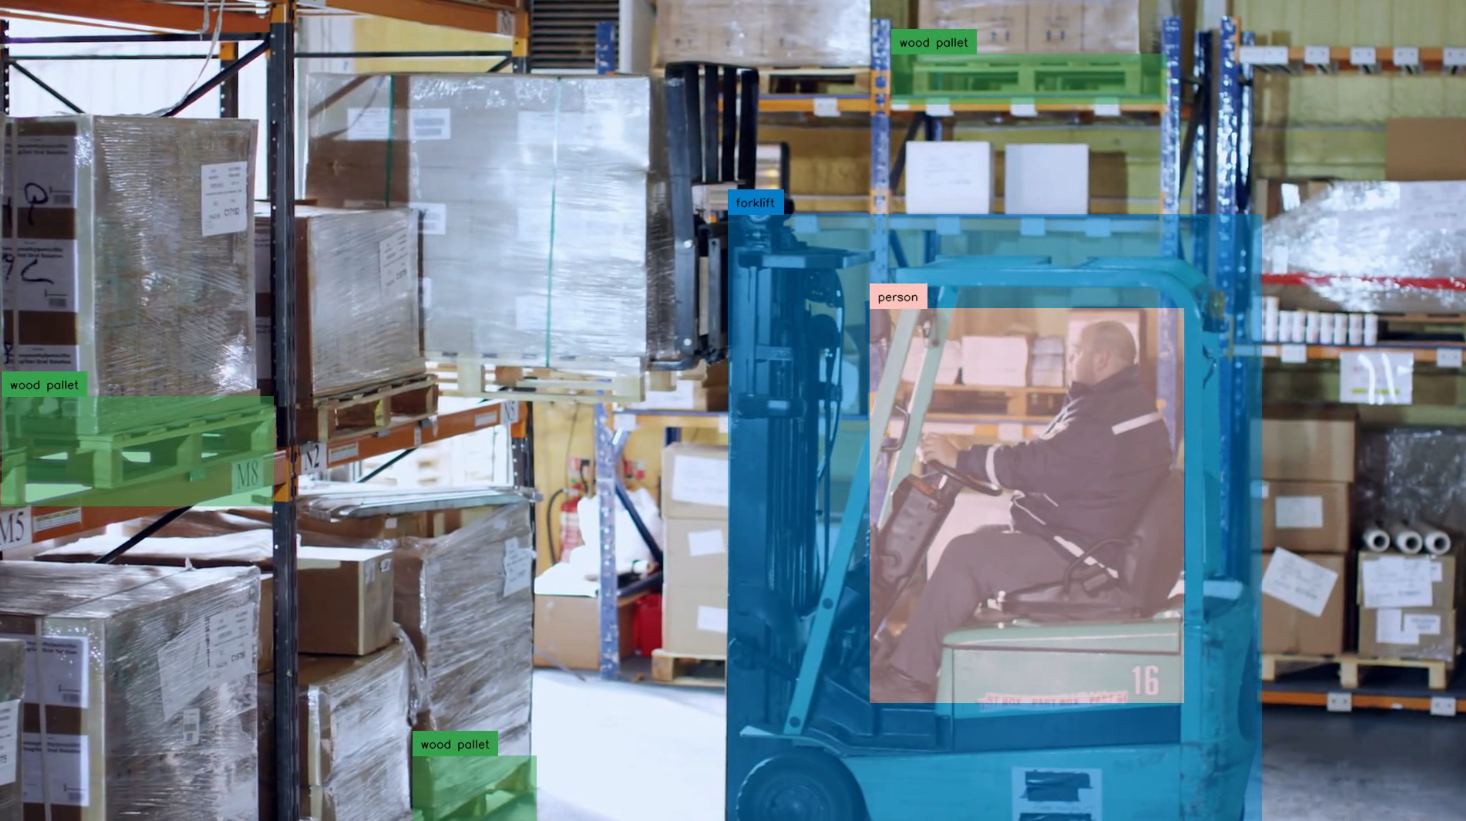

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.


### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.